In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%pwd

'/content'

In [3]:
%cd '/content/drive/MyDrive/Colab Notebooks/nlg_lstm'
!ls

/content/drive/MyDrive/Colab Notebooks/nlg_lstm
code  data  model  requirements.txt  resource


In [4]:
!pip install underthesea

  Using cached https://files.pythonhosted.org/packages/a4/cf/007b6de316c9f3d4cb315a60c308342cc299e464167f5ebc369e93b5e23a/torch-1.5.1-cp37-cp37m-manylinux1_x86_64.whl
ERROR: torchvision 0.9.1+cu101 has requirement torch==1.8.1, but you'll have torch 1.5.1 which is incompatible.
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.5.1 which is incompatible.
  Found existing installation: torch 1.7.0+cpu
    Uninstalling torch-1.7.0+cpu:
      Successfully uninstalled torch-1.7.0+cpu


In [5]:
!pip install -r requirements.txt

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 577.3MB 29kB/s 
ERROR: underthesea 1.3.1 has requirement torch<=1.5.1,>=1.1.0, but you'll have torch 1.7.0+cu92 which is incompatible.
ERROR: torchvision 0.9.1+cu101 has requirement torch==1.8.1, but you'll have torch 1.7.0+cu92 which is incompatible.
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.0+cu92 which is incompatible.
  Found existing installation: torch 1.5.1
    Uninstalling torch-1.5.1:
      Successfully uninstalled torch-1.5.1


In [6]:
%cd '/content/drive/MyDrive/Colab Notebooks/nlg_lstm/code'

/content/drive/MyDrive/Colab Notebooks/nlg_lstm/code


In [7]:
!ls

forward.ipynb  prepare_data.ipynb	 train_nlg_lstm_vi.ipynb
helper	       train_nlg_lstm_eng.ipynb


In [8]:
%cd helper

/content/drive/MyDrive/Colab Notebooks/nlg_lstm/code/helper


In [55]:

from utils import get_batches,tokenize
from model import WordLSTM

In [51]:
%load_ext autoreload
%autoreload 2
import torch
import os
import numpy as np
import random
# from helper.utils import get_batches
# from helper.model import WordLSTM

import torch.nn as nn
import torch.nn.functional as F

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# _DATA_PATH = '/home/taindp/VINBRAIN_INTERNSHIP/nlg_lstm/data'
# _RESOURCE_PATH = '/home/taindp/VINBRAIN_INTERNSHIP/nlg_lstm/resource'

In [12]:
_DATA_PATH = '../../data'
_RESOURCE_PATH = '../../resource'

In [13]:
int2token = torch.load(os.path.join(_RESOURCE_PATH,'int2token_vi.h5'))

token2int = torch.load(os.path.join(_RESOURCE_PATH,'token2int_vi.h5'))

x_int = torch.load(os.path.join(_RESOURCE_PATH,'x_train.h5'))
y_int = torch.load(os.path.join(_RESOURCE_PATH,'y_train.h5'))

In [14]:
# set vocabulary size
vocab_size = len(int2token)

In [15]:
net = WordLSTM(vocab_size)

print(net)

WordLSTM(
  (emb_layer): Embedding(656, 200)
  (lstm): LSTM(200, 256, num_layers=4, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=656, bias=True)
)


In [16]:
def train(net, epochs=10, batch_size=32, lr=0.001, clip=1, print_every=32):
    # invest loss
    invest_loss = []

    # optimizer
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    
    # loss
    criterion = nn.CrossEntropyLoss()
    
    # push model to GPU
    net.cuda()
    
    counter = 0

    net.train()

    for e in range(epochs):

        # initialize hidden state
        h = net.init_hidden(batch_size)
        
        for x, y in get_batches(x_int, y_int, batch_size):
            counter+= 1
            
            # convert numpy arrays to PyTorch arrays
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
            
            # push tensors to GPU
            inputs, targets = inputs.cuda(), targets.cuda()

            # detach hidden states
            h = tuple([each.data for each in h])

            # zero accumulated gradients
            net.zero_grad()
            
            # get the output from the model
            output, h = net(inputs, h)
            
            # calculate the loss and perform backprop
            loss = criterion(output, targets.view(-1))

            # invest loss
            invest_loss.append(loss)

            # back-propagate error
            loss.backward()

            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)

            # update weigths
            opt.step()            
            
            if counter % print_every == 0:
            
              print("Epoch: {}/{}...".format(e+1, epochs),
                    "Loss: {}...".format(loss),
                    "Step: {}...".format(counter))
    return invest_loss

In [17]:
# train the model
invest_loss = train(net, batch_size = 6, epochs=50, print_every=128)

Epoch: 1/50... Loss: 7.101609706878662... Step: 128...
Epoch: 1/50... Loss: 5.992701530456543... Step: 256...
Epoch: 2/50... Loss: 4.545989036560059... Step: 384...
Epoch: 2/50... Loss: 4.850392818450928... Step: 512...
Epoch: 2/50... Loss: 5.459654808044434... Step: 640...
Epoch: 3/50... Loss: 4.7125043869018555... Step: 768...
Epoch: 3/50... Loss: 5.215477466583252... Step: 896...
Epoch: 3/50... Loss: 5.308009147644043... Step: 1024...
Epoch: 4/50... Loss: 5.234268665313721... Step: 1152...
Epoch: 4/50... Loss: 4.610501766204834... Step: 1280...
Epoch: 4/50... Loss: 5.658463954925537... Step: 1408...
Epoch: 5/50... Loss: 4.454002857208252... Step: 1536...
Epoch: 5/50... Loss: 4.157093524932861... Step: 1664...
Epoch: 6/50... Loss: 3.969088554382324... Step: 1792...
Epoch: 6/50... Loss: 4.897918224334717... Step: 1920...
Epoch: 6/50... Loss: 4.74925422668457... Step: 2048...
Epoch: 7/50... Loss: 5.628000736236572... Step: 2176...
Epoch: 7/50... Loss: 4.864607334136963... Step: 2304...

In [18]:
net

WordLSTM(
  (emb_layer): Embedding(656, 200)
  (lstm): LSTM(200, 256, num_layers=4, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=656, bias=True)
)

In [19]:
_MODEL_PATH = '../../model'

In [31]:
torch.save(net,os.path.join(_MODEL_PATH,'model_vi.pth'))

In [33]:
# torch.load(os.path.join(_MODEL_PATH,'model_vi.pth'))

In [20]:
checkpoint = {'model': net,
      'state_dict': net.state_dict()}

torch.save(checkpoint, os.path.join(_MODEL_PATH,'checkpoint_vi.pth'))

In [28]:
# len(invest_loss)

In [24]:
invest_loss_numpy = [item.item() for item in invest_loss]
invest_loss_numpy 

[6.501484394073486,
 6.49273681640625,
 6.47206449508667,
 6.468482971191406,
 6.465280532836914,
 6.40570068359375,
 6.4587249755859375,
 6.341085433959961,
 6.358613014221191,
 6.48123836517334,
 6.437428951263428,
 6.3840532302856445,
 6.346249580383301,
 6.319355487823486,
 5.670726299285889,
 5.050302028656006,
 6.327284812927246,
 5.584715843200684,
 5.215735912322998,
 5.785263538360596,
 6.309386730194092,
 6.689265251159668,
 7.16179084777832,
 7.059702396392822,
 5.67474365234375,
 6.921143531799316,
 4.571594715118408,
 5.505712032318115,
 5.314191818237305,
 6.53891658782959,
 5.5521559715271,
 5.81978702545166,
 6.136711120605469,
 6.450254917144775,
 6.1487202644348145,
 5.4654693603515625,
 5.95026159286499,
 6.2467522621154785,
 6.819899559020996,
 6.475656032562256,
 5.307099342346191,
 4.701756000518799,
 5.4096503257751465,
 5.833298206329346,
 5.707243919372559,
 7.13271951675415,
 5.925123691558838,
 5.774936199188232,
 5.400308609008789,
 5.326204776763916,
 6.702

In [25]:
len(invest_loss_numpy)

17650

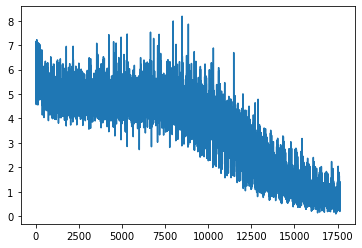

In [26]:
import matplotlib.pyplot as plt
plt.plot(invest_loss_numpy)

In [52]:
def predict(net,tkn,h=None):
    
    x = np.array([[token2int[tkn]]])
    inputs = torch.from_numpy(x)
    
    inputs = inputs.cuda()
    h = tuple([each.data for each in h])
    
    out,h = net(inputs,h)
    
    p = F.softmax(out,dim=1).data
    
    p = p.cuda()
    p = p.cpu().numpy()
    p = p.reshape(p.shape[1],)
    
    top_n_idx = p.argsort()[-3:][::-1]
    
    sampled_token_index = top_n_idx[random.sample([0,1,2],1)[0]]
    
    return int2token[sampled_token_index],h
    

In [57]:
def sample(net,size,prime='it is'):
    # net.cuda()
    net.eval()
    
    h = net.init_hidden(1)
    # toks = prime.split()
    toks = tokenize(prime)
    
    #predict next token
    
    # for t in prime.split():
    for t in tokenize(prime):
        token,h = predict(net,t,h)
        
    toks.append(token)
    
    for i in range(size-1):
        token,h = predict(net,toks[-1],h)
        toks.append(token)
    return ' '.join(toks)

In [59]:
sample(net,15,prime = 'bệnh về máu')

'bệnh về máu , bắt đầu các hạch tế bào hồng cầu mang bên bên phải và bụng , dưới tỷ lệ'